In [1]:
from sparse_pca import *
import pandas as pd
from sklearn.decomposition import SparsePCA
from datetime import datetime
from scipy.linalg import orth
import numpy as np

Load the dataset

In [2]:
X_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1).drop(['Class'],axis=1).to_numpy()
y_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1)['Class'].to_numpy()

y_small = preprocessing.LabelEncoder().fit_transform(y_small)

In [20]:
class PCAObject:
    def __init__(self, PCs, X, label):
        assert len(PCs) == min(X.shape[0],X.shape[1]), "Need all the principal components!"
        self.pcs = PCs
        self.X = StandardScaler(with_mean = False).fit_transform(X)
        self.cov = np.cov(self.X.T)
        self.label = label
        
        self._calcExpVar()
        self._calcNonZeroLoads()
        self._calcGini()
        self._calcSparsity()    
    
    def _checkOrtho(self):
        # Check if the Principal components are orthogonal
        norm = np.linalg.norm(self.pcs @ self.pcs.T - np.identity(len(self.pcs)))
        return norm < 1e-2
    
    def _calcExpVar(self):
        self.ev = Adj_Var(self.X, self.pcs)
        self.pev = self.ev/np.sum(self.ev)
        self.cev = np.cumsum(np.flip(np.sort(self.pev)))
        self.evd = gini(np.asarray(self.pev))
        
    def _calcNonZeroLoads(self):
        self.nonZeroLoads = [np.count_nonzero(pc) for pc in self.pcs]
        
    def _calcGini(self):
        self.gini = [gini(i) for i in self.pcs]
        
    def _calcSparsity(self):
        self.sparsity = np.sum([gini * pev for gini, pev in zip(self.gini, self.pev)])
        
    def plotNonZeroLoadtoPEV(self):
        plt.plot(self.nonZeroLoads, self.pev, label=self.label)
        plt.xlabel('Number of non-zero loadings')
        plt.xscale('log')
        plt.ylabel('Percentage of explained variance (PEV)')
        plt.legend()
        plt.title('Percentage of explained variance (PEV) vs non-zero loadings')
        
    def plotCEV(self):
        x = np.arange(len(self.pcs))
        
        plt.plot(x, np.sort(self.cev), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Cumulative explained variance (CEV)')
        plt.legend()
        plt.title('Cumulative explained variance (CEV)')
        
    def plotSparsitytoEV(self,k): #k is which PC you want to plot
        plt.scatter(self.gini[k], self.ev[k], label = self.label)
        plt.xlabel('Sparsity of PC '+str(k+1))
        plt.ylabel('Explained Variance of PC '+str(k+1))
        plt.xlim((0,1))
        plt.legend()
        plt.title('Sparsity of PC versus Expained Variance of PC '+str(k+1))
        
    def plotSparsity(self):
        x = np.arange(len(self.pcs))
        
        plt.scatter(x, np.sort(self.gini))
        plt.plot(x, np.sort(self.gini), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Sparsity of Loadings')
        plt.legend()
        plt.title('Sparsity of Components')

We want four rows: PCA, SCoT, SCoTLASS, SPCA for their "best" specification. We will show the difference within each model in tables and figures in the appendix. Columns containing: Weighted Gini coefficient, distribution of explained variance

In [5]:
def table_builder(function, params, X):
    if len(params.keys()) > 0:
        results_table = pd.DataFrame(params)
        results_table = results_table.set_index(list(params.keys()))
    else:
        results_table = pd.DataFrame(index = [1])

    for column in ['Concentration of EV', 'Sparsity', 'Run Time (sec)']:
        results_table[column] = np.nan

    for index, row in results_table.iterrows():
        start = datetime.now()
        if len(params.keys()) == 0:
            PCs = function(X)
        elif len(params.keys()) == 1:
            PCs = function(X, index)
        else:
            PCs = function(X, index[0], index[1])
        obj = PCAObject(PCs, X_small, "")
        stop = datetime.now()

        evd = obj.evd
        spa = obj.sparsity
        runtime = "{runtime:d}".format(runtime = (stop - start).seconds)
        results_table.loc[index] = [evd, spa, runtime]
    return results_table

In [6]:
def function(X):
    return reg_PCA(X)[1]
params = {}
PCA_df = table_builder(function, params, X_small)
with open('../Tables/PCA.tex', 'w') as file:
        file.write(PCA_df.to_latex(column_format = "cccc",
                                   index = False,
                                   float_format = "%.2f",
                                   escape = False))

In [7]:
def function(X, reg):
    return SCoT(X, reg)
params = {"$\lambda$": [10, 100, 500, 1000]}
SCoT_df = table_builder(function, params, X_small)
with open('../Tables/SCoT.tex', 'w') as file:
        file.write(SCoT_df.to_latex(column_format = "r|cccc",
                                    float_format = "%.2f",
                                    escape = False))

In [8]:
def function(X, reg):
    return SCoTLASS(X, reg, alpha = 1e-6)
params = {"$\lambda$": [1, 1.2, 1.5, 1.6, 2]}
SCoTLASS_df = table_builder(function, params, X_small)
with open('../Tables/SCoTLASS.tex', 'w') as file:
        file.write(SCoTLASS_df.to_latex(column_format = "r|cccc",
                                        float_format = "%.2f",
                                        escape = False))

In [15]:
def function(X, reg, reg2):
    transformer = SparsePCA(n_components = 9, alpha = reg, ridge_alpha = reg2)
    transformer.fit(X)
    return transformer.components_
params = {"$\lambda_1$": [5e-3, 1e-2, 1.5e-2, 2e-2, 2.5e-2], 
          "$\lambda_2$": [0.1, 0.1, 0.1, 0.1, 0.1]}
SPCA_df = table_builder(function, params, X_small)
with open('../Tables/SPCA.tex', 'w') as file:
        file.write(SPCA_df.to_latex(column_format = "rr|cccc",
                                    float_format = "%.2f",
                                    escape = False))

In [16]:
SPCA_df

,,Concentration of EV,Sparsity,Run Time (sec)
$\lambda_1$,$\lambda_2$,,,
0.005,0.1,0.378846,0.495917,9
0.010,0.1,0.377781,0.416156,9
0.015,0.1,0.375463,0.329132,10
0.020,0.1,0.371324,0.315178,10
0.025,0.1,0.365743,0.311021,14


In [63]:
def scot_wrapper(reg_param):
    PCs = PCAObject(SCoT(X_small, reg_param, alpha = 10**-2, max_iter = 5e5), X_small, " ")
    return PCs.sparsity

In [64]:
reg_params = np.geomspace(0.01, 1000, num = 10).reshape(-1,1)
plot = np.apply_along_axis(scot_wrapper, axis = 1, arr = reg_params)

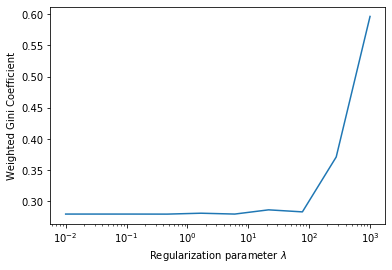

In [65]:
plt.plot(reg_params, plot)
plt.xlabel("Regularization parameter $\lambda$")
plt.xscale("log")
plt.ylabel("Weighted Gini Coefficient")
plt.show()

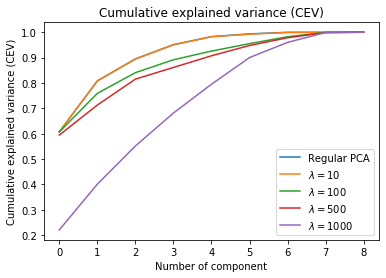

In [42]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular PCA")
reg_scot_10 = PCAObject(SCoT(X_small, 10, alpha = 10**-3), X_small, "$\lambda = 10$")
reg_scot_100 = PCAObject(SCoT(X_small, 100, alpha = 10**-3), X_small, "$\lambda = 100$")
reg_scot_500 = PCAObject(SCoT(X_small, 500, alpha = 10**-3), X_small, "$\lambda = 500$")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "$\lambda = 1000$")

reg_reg.plotCEV()
reg_scot_10.plotCEV()
reg_scot_100.plotCEV()
reg_scot_500.plotCEV()
reg_scot_1000.plotCEV()
plt.savefig("../Figures/SCoT_comparison.pdf", bbox_inches = 'tight')

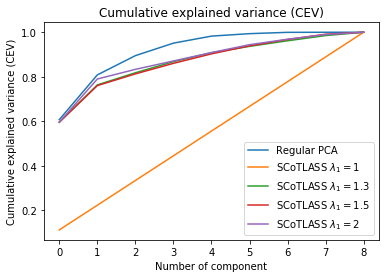

In [38]:
reg_reg.plotCEV()
reg_scotlass_1.plotCEV()
reg_scotlass_1pt3.plotCEV()
reg_scotlass_1pt5.plotCEV()
reg_scotlass_2.plotCEV()
plt.savefig("../Figures/SCoTLASS_comparison.pdf", bbox_inches = 'tight')

In [21]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "PCA")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "SCoT")
reg_scotlass_1pt5 = PCAObject(SCoTLASS(X_small,1.5,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS")
reg_spca_100_0pt1 = PCAObject(SparsePCA(n_components = 9, alpha = 0.005, ridge_alpha = 0.1).fit(X_small).components_, X_small, "SPCA")

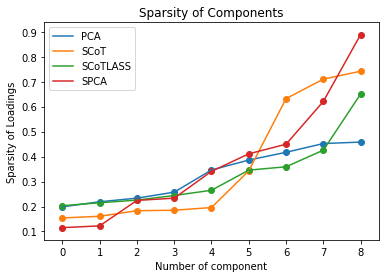

In [22]:
reg_reg.plotSparsity()
reg_scot_1000.plotSparsity()
reg_scotlass_1pt5.plotSparsity()
reg_spca_100_0pt1.plotSparsity()
plt.savefig("../Figures/sparsityOfComponents.pdf", bbox_inches = 'tight')

In [40]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")

reg_scot_500 = PCAObject(SCoT(X_small, 500, alpha = 10**-3), X_small, "SCoT 500")
reg_scot_750 = PCAObject(SCoT(X_small, 750, alpha = 10**-3), X_small, "SCoT 750")
reg_scot_1000 = PCAObject(SCoT(X_small, 1000, alpha = 10**-3), X_small, "SCoT 1000")
reg_scot_5000 = PCAObject(SCoT(X_small, 5000, alpha = 10**-3), X_small, "SCoT 5000")

reg_scotlass_1 = PCAObject(SCoTLASS(X_small,1,alpha = 10**-6, max_iter = 500000), X_small, "SCoTLASS 1")
reg_scotlass_1pt3 = PCAObject(SCoTLASS(X_small,1.3,alpha = 1.5*10**-6, max_iter = 500000), X_small, "SCoTLASS 1.3")
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.5")
reg_scotlass_1pt6= PCAObject(SCoTLASS(X_small,1.6,alpha = 2*10**-6, max_iter=500000), X_small, "SCoTLASS 1.6")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 2*10**-6, max_iter=1000000), X_small, "SCoTLASS 2")

reg_reg_ord = list(reversed(np.argsort(abs(reg_reg.pcs[0]))))+np.ones(len(reg_reg.pcs[0]))

reg_scot_500_ord = list(reversed(np.argsort(abs(reg_scot_500.pcs[0]))))+np.ones(len(reg_scot_500.pcs[0]))
reg_scot_750_ord = list(reversed(np.argsort(abs(reg_scot_750.pcs[0]))))+np.ones(len(reg_scot_750.pcs[0]))
reg_scot_1000_ord = list(reversed(np.argsort(abs(reg_scot_1000.pcs[0]))))+np.ones(len(reg_scot_1000.pcs[0]))
reg_scot_5000_ord = list(reversed(np.argsort(abs(reg_scot_5000.pcs[0]))))+np.ones(len(reg_scot_5000.pcs[0]))

reg_scotlass_1_ord = list(reversed(np.argsort(abs(reg_scotlass_1.pcs[0]))))+np.ones(len(reg_scotlass_1.pcs[0]))
reg_scotlass_1pt3_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt3.pcs[0]))))+np.ones(len(reg_scotlass_1pt3.pcs[0]))
reg_scotlass_1pt5_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt5.pcs[0]))))+np.ones(len(reg_scotlass_1pt5.pcs[0]))
reg_scotlass_1pt6_ord = list(reversed(np.argsort(abs(reg_scotlass_1pt6.pcs[0]))))+np.ones(len(reg_scotlass_1pt6.pcs[0]))
reg_scotlass_2_ord = list(reversed(np.argsort(abs(reg_scotlass_2.pcs[0]))))+np.ones(len(reg_scotlass_2.pcs[0]))

ordered_loadings = np.array([reg_reg_ord,
                    reg_scot_500_ord,
                    reg_scot_750_ord,
                    reg_scot_1000_ord,
                    reg_scot_5000_ord,
                    reg_scotlass_2_ord,
                    reg_scotlass_1pt5_ord,
                    reg_scotlass_1pt3_ord,
                    reg_scotlass_1_ord])

gini_coefs = np.array([reg_reg.gini[0],
              reg_scot_500.gini[0],    
              reg_scot_750.gini[0],             
              reg_scot_1000.gini[0],
              reg_scot_5000.gini[0],
              reg_scotlass_2.gini[0],
              reg_scotlass_1pt5.gini[0],                    
              reg_scotlass_1pt3.gini[0],
              reg_scotlass_1.gini[0]])

pevs = np.array([reg_reg.pev[0],
              reg_scot_500.pev[0],    
              reg_scot_750.pev[0],             
              reg_scot_1000.pev[0],
              reg_scot_5000.pev[0],
              reg_scotlass_2.pev[0],
              reg_scotlass_1pt5.pev[0],                    
              reg_scotlass_1pt3.pev[0],
              reg_scotlass_1.pev[0]])

gini_coefs = np.reshape(gini_coefs,(len(gini_coefs),1))

pevs = np.reshape(pevs,(len(pevs),1))

weighted_gini = gini_coefs * pevs

df_data = np.concatenate((gini_coefs, pevs, weighted_gini, ordered_loadings), 1)

rows = ['PCA',
        'SCoT (reg_param = 500)',
        'SCoT (reg_param = 750)',
        'SCoT (reg_param = 1000)',
        'SCoT (reg_param = 5000)',
        'SCoTLASS (reg_param = 2)',
        'SCoTLASS (reg_param = 1.5)',
        'SCoTLASS (reg_param = 1.3)',
        'SCoTLASS (reg_param = 1)']

cols = ['gini','pev','weighted gini']+['%d' %(i+1) for i in range(X_small.shape[1])]
ordered_load_df = pd.DataFrame(df_data,index = rows, columns = cols)
ordered_load_df = ordered_load_df.astype({'1': int, '2': int, '3': int, '4': int, '5': int, 
                                          '6': int, '7': int, '8': int, '9': int})

with open('../Tables/orderedLoads.tex', 'w') as file:
        file.write(ordered_load_df.to_latex(column_format = "rr|cccc",
                                            float_format = "%.2f",
                                            escape = False))